In [1]:
!pip3 install opencv-python
!pip3 install tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/central/software/python/3.7.0/bin/python3.7 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/central/software/python/3.7.0/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from numpy import asarray
import PIL
from PIL import Image

import cv2

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, Conv2D


In [3]:
# Load data

train = pd.read_csv('/groups/CS156b/data/student_labels/train.csv')

test_ids = pd.read_csv('/groups/CS156b/data/student_labels/test_ids.csv')

solution_ids = pd.read_csv('/groups/CS156b/data/student_labels/solution_ids.csv')

In [4]:
# Use subset of the data for models

num_train = 100
num_test = 50

train_sub = train.sample(n=num_train)
test_sub = test_ids.sample(n=num_test)
solution_ids_sub = solution_ids.sample(n=num_test)

In [5]:
# Convert all training images into numpy arrays

train_imgs = []
init_path = '/groups/CS156b/data/'

for i, row in train_sub.iterrows():
    temp_img = Image.open(init_path + row['Path'])
    train_imgs.append(asarray(temp_img))
    
train_imgs = np.array(train_imgs)

/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [6]:
test_imgs = []
init_path = '/groups/CS156b/data/'

for i, row in test_sub.iterrows():
    temp_img = Image.open(init_path + row['Path'])
    test_imgs.append(asarray(temp_img))
    
test_imgs = np.array(test_imgs)

/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [7]:
solution_imgs = []
init_path = '/groups/CS156b/data/'

for i, row in solution_ids_sub.iterrows():
    temp_img = Image.open(init_path + row['Path'])
    solution_imgs.append(asarray(temp_img))
    
solution_imgs = np.array(solution_imgs)

/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [8]:
print(train_imgs[0].shape)

(2320, 2828)


In [9]:
img_large = Image.fromarray(train_imgs[0], 'L')

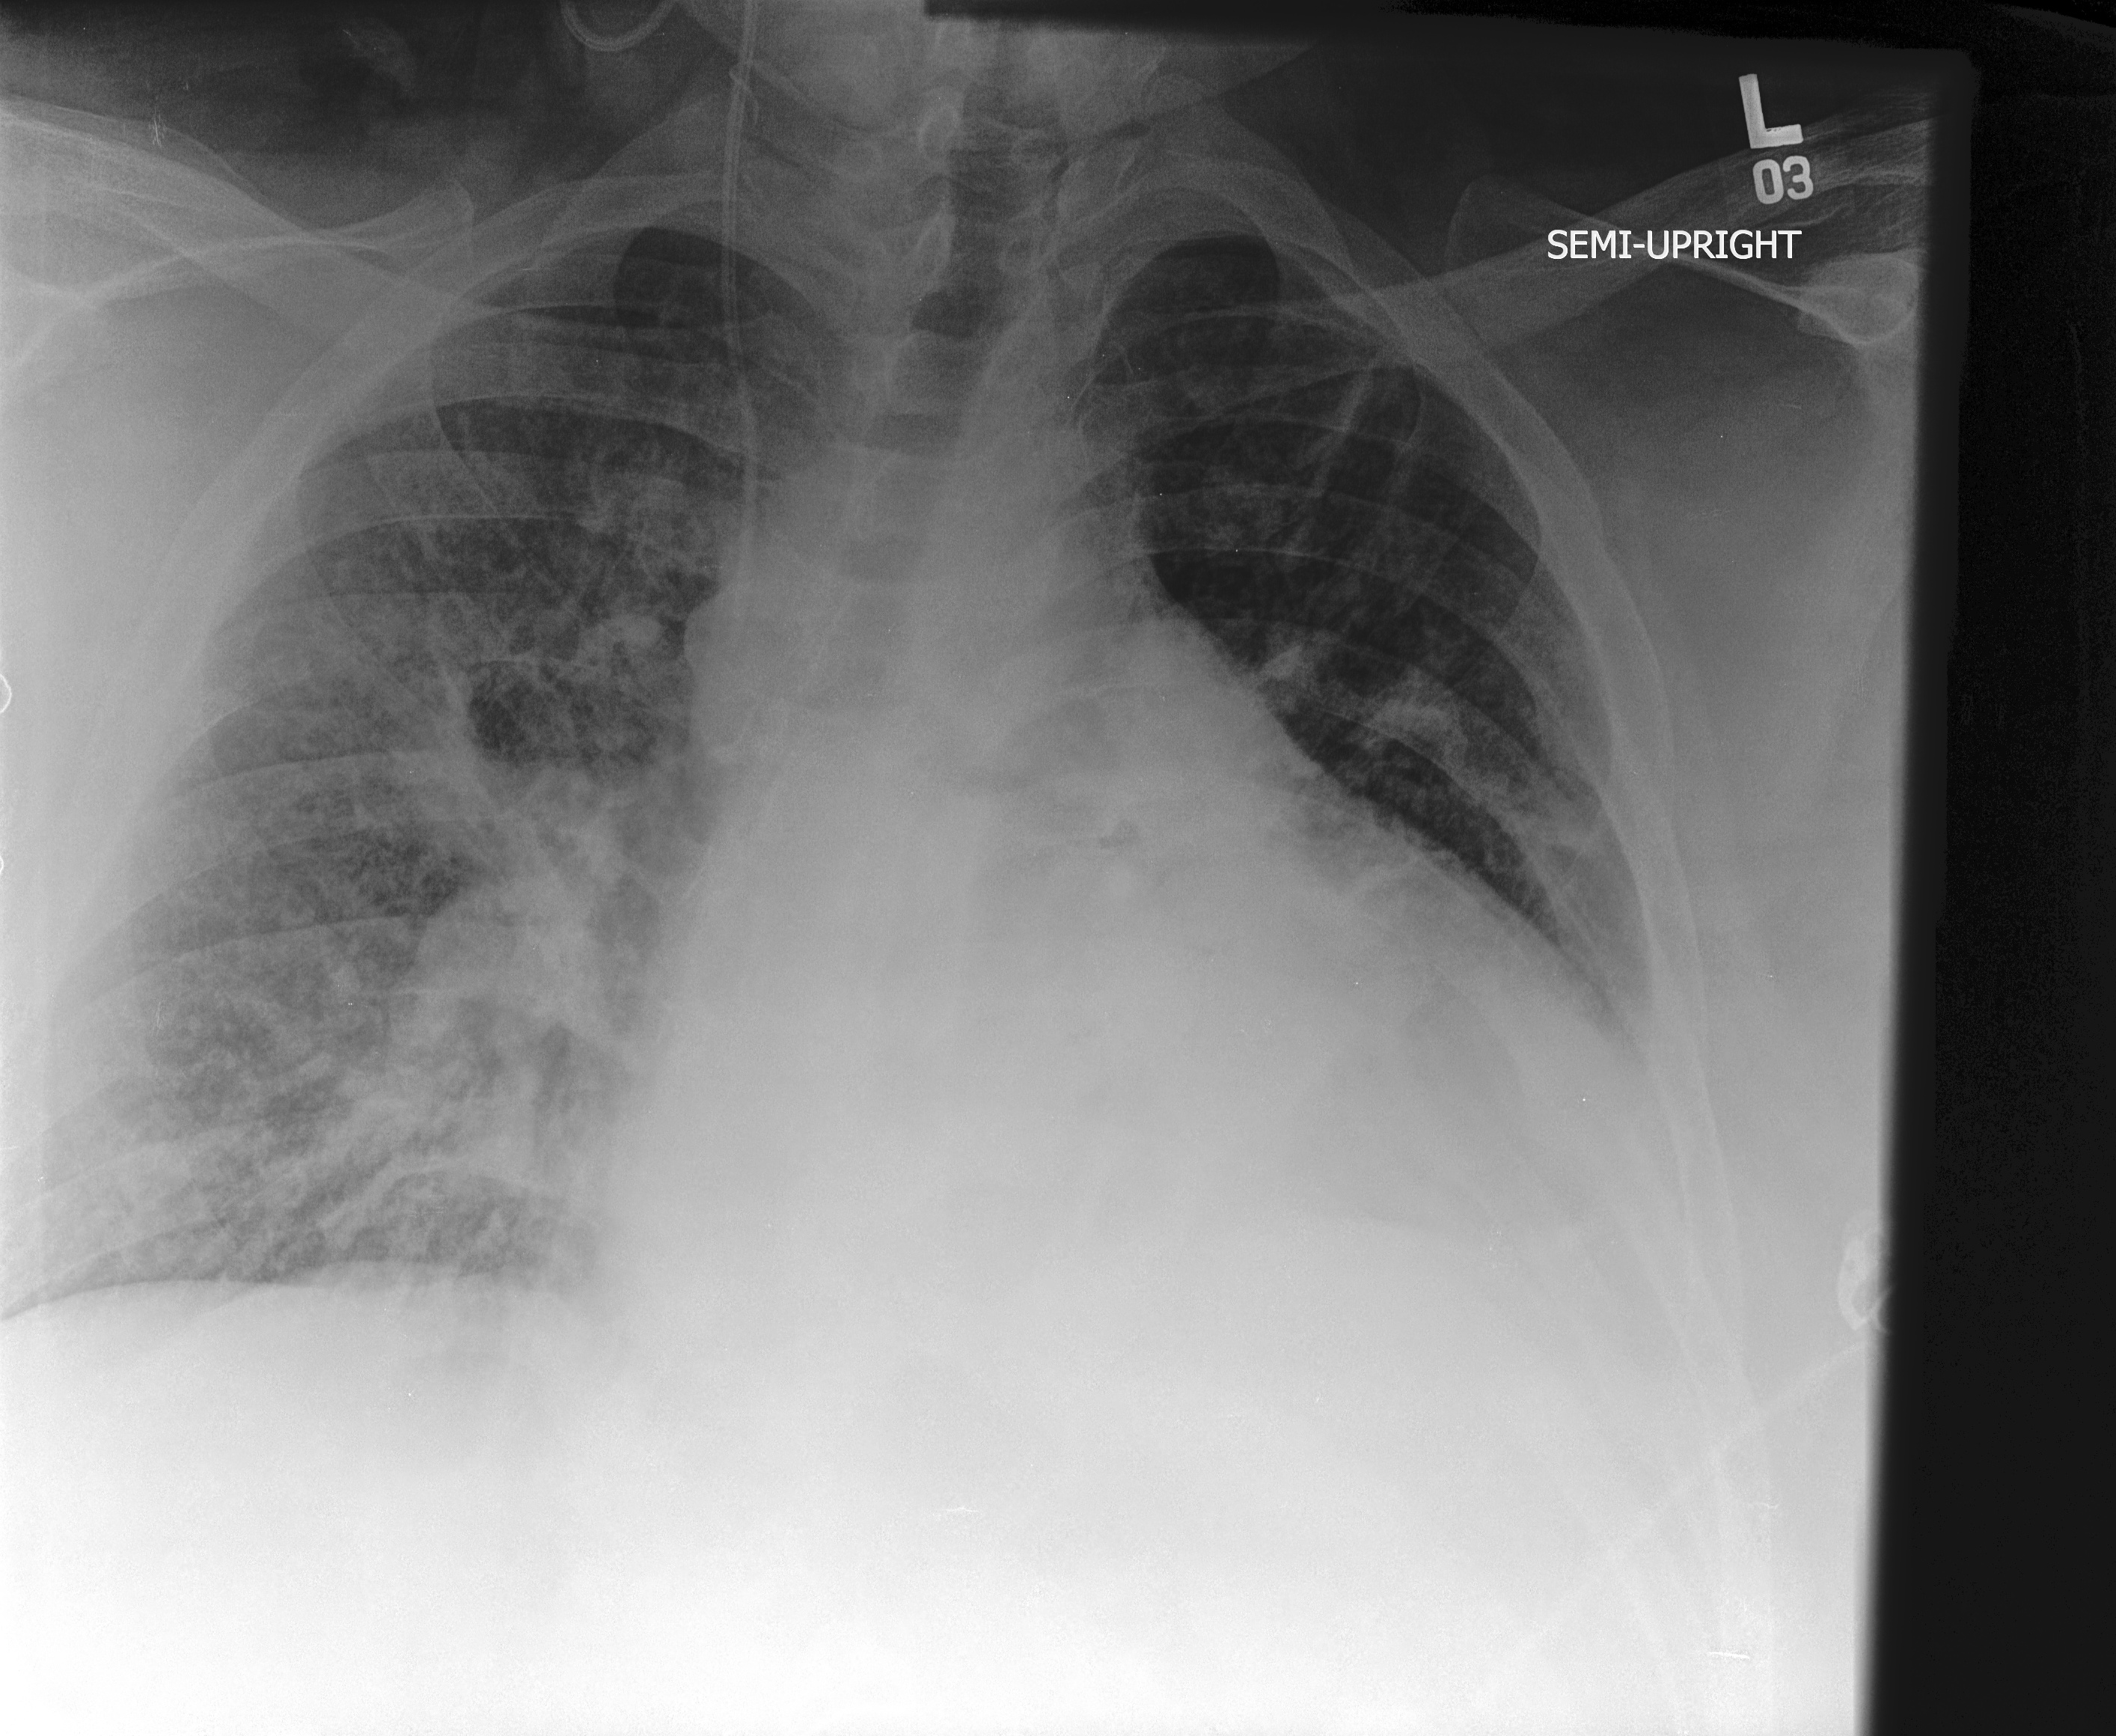

In [10]:
img_large

In [11]:
width = 100
height = 100

curr = cv2.resize(train_imgs[0], (width, height))

print(curr.shape)
print(curr)

img = Image.fromarray(curr, 'L')

(100, 100)
[[ 37  34  34 ...   0   0   0]
 [ 60  46  45 ...  20  23  22]
 [ 82  68  62 ...   7  13  20]
 ...
 [255 254 254 ...  22  23  22]
 [255 255 254 ...  22  23  23]
 [255 255 255 ...  22  23  22]]


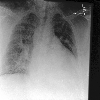

In [12]:
img

In [13]:
tensor_train = []
tensor_test = []
tensor_solution = []

In [14]:
for i in range(0, len(train_imgs)):
    train_imgs[i] = cv2.resize(train_imgs[i], (width, height))
    train_imgs[i] = train_imgs[i]/255
    tensor_train.append(tf.convert_to_tensor(train_imgs[i], dtype=float))
    
for i in range(0, len(test_imgs)):
    test_imgs[i] = cv2.resize(test_imgs[i], (width, height))
    test_imgs[i] = test_imgs[i]/255
    tensor_test.append(tf.convert_to_tensor(test_imgs[i], dtype=float))

    
for i in range(0, len(solution_imgs)):
    solution_imgs[i] = cv2.resize(solution_imgs[i], (width, height))
    solution_imgs[i] = solution_imgs[i]/255
    tensor_solution.append(tf.convert_to_tensor(solution_imgs[i], dtype=float))

In [15]:
y_train = []
for index, row in train_sub.iterrows():
    temp2 = [row['No Finding'], row['Enlarged Cardiomediastinum'], row['Cardiomegaly'],
            row['Lung Opacity'], row['Lung Lesion'], row['Edema'], row['Consolidation'],
            row['Pneumonia'], row['Atelectasis'], row['Pneumothorax'], row['Pleural Effusion'], 
            row['Pleural Other'], row['Fracture'], row['Support Devices']]
    i = 0 
    for val in temp2: 
        if val != val:
            temp2[i] = 0.0
        i += 1
    y_train.append(temp2)

In [16]:
X_train = train_imgs
y_train = np.array(y_train)

print(type(X_train[0][0]))
print()

<class 'numpy.ndarray'>



In [17]:
# setting training data to be a tensor of tensor-ed images
# shape: n training images, shape width, shape height
train_tensor_of_tensors = tf.convert_to_tensor(tensor_train)
print(train_tensor_of_tensors.shape)

(100, 100, 100)


In [18]:
num_classes = 14

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=[width, height, 1]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(train_tensor_of_tensors, y_train, epochs=10, verbose=1)

Epoch 1/10
4/4 [==============================] - 6s 1s/step - loss: 1.2612 - accuracy: 0.0400
Epoch 2/10
4/4 [==============================] - 6s 1s/step - loss: 1.1028 - accuracy: 0.0500
Epoch 3/10
4/4 [==============================] - 6s 1s/step - loss: 0.9195 - accuracy: 0.0700
Epoch 4/10
4/4 [==============================] - 6s 1s/step - loss: 0.7353 - accuracy: 0.1900
Epoch 5/10
4/4 [==============================] - 6s 1s/step - loss: 0.5496 - accuracy: 0.2900
Epoch 6/10
4/4 [==============================] - 6s 1s/step - loss: 0.3268 - accuracy: 0.3400
Epoch 7/10
4/4 [==============================] - 6s 1s/step - loss: 0.1188 - accuracy: 0.3400
Epoch 8/10
4/4 [==============================] - 6s 1s/step - loss: -0.0894 - accuracy: 0.3400
Epoch 9/10
4/4 [==============================] - 5s 1s/step - loss: -0.2781 - accuracy: 0.3400
Epoch 10/10
4/4 [==============================] - 6s 1s/step - loss: -0.4640 - accuracy: 0.3400


In [20]:
# Simple neural network


# Create simple Neural Network model
model = Sequential()
model.add(Flatten(input_shape=(100,100)))
model.add(Dense(100, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

model.fit(train_tensor_of_tensors, y_train, epochs=10, verbose=1)

Epoch 1/10


ValueError: in user code:

    File "/home/lgriffit/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/lgriffit/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lgriffit/.local/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/lgriffit/.local/lib/python3.7/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/lgriffit/.local/lib/python3.7/site-packages/keras/engine/training.py", line 919, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "/home/lgriffit/.local/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/lgriffit/.local/lib/python3.7/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/lgriffit/.local/lib/python3.7/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/lgriffit/.local/lib/python3.7/site-packages/keras/losses.py", line 1790, in categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    File "/home/lgriffit/.local/lib/python3.7/site-packages/keras/backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 14) and (None, 100) are incompatible


In [ ]:
print(X_train)
print(y_train.shape)